<a href="https://colab.research.google.com/github/Zahid8/Major-Project---Retinal-OCT/blob/main/Copy_of_OCT_denoising_using_Autoencoders_SSIM_PSNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/pdf/1608.04667.pdf

In [ ]:
import numpy as np
import pandas as pd 
import os

In [ ]:
from keras.preprocessing import image
import tensorflow as tf 
import keras 
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import os

com_wget = "sudo wget " +"https://github.com/prasmussen/gdrive/releases/download/2.1.1/gdrive_2.1.1_linux_386.tar.gz"
com_unzip = "sudo tar -xzf gdrive_2.1.1_linux_386.tar.gz"
com_permission = "sudo chmod +x gdrive"
com_install_executor = "sudo install gdrive /usr/local/bin/gdrive"

os.system(com_wget)
os.system(com_unzip)
os.system(com_permission)
os.system(com_install_executor)

In [ ]:
!sudo gdrive list

In [ ]:
import zipfile

!gdrive download 12GFYb613xKHWTd09ph2zBrZnauayOgBT

zipref=zipfile.ZipFile("/content/virtual_sar_training_set.zip",'r')
zipref.extractall()
zipref.close()

!rm -rf /content/virtual_sar_training_set.zip

In [ ]:
train_images = sorted(os.listdir('/content/clean_1c'))
train_images = train_images[:2000]

train_image = []
for im in train_images:
    img = tf.keras.utils.load_img('/content/clean_1c/'+ im, target_size=(180,180), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

In [ ]:
noised_images = sorted(os.listdir('/content/noisy_1c'))
noised_images = noised_images[:2000]

noised_image = []
for im in noised_images:
    img = tf.keras.utils.load_img('/content/noisy_1c/'+ im, target_size=(180,180), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    noised_image.append(img)
noised_df = np.array(noised_image)

In [ ]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(180,180), cmap='gray')
    plt.show()

In [ ]:
xnoised= noised_df[0:1000]
xtest= noised_df[1000:]

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():
    
    input_img = Input(shape=(180,180,1), name='image_input')
    
    #enoder 
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    
    #decoder
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [ ]:
model= autoencoder()
#model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 180, 180, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 180, 180, 180)     1800      
                                                                 
 pool1 (MaxPooling2D)        (None, 90, 90, 180)       0         
                                                                 
 Conv2 (Conv2D)              (None, 90, 90, 180)       291780    
                                                                 
 pool2 (MaxPooling2D)        (None, 45, 45, 180)       0         
                                                                 
 Conv3 (Conv2D)              (None, 45, 45, 180)       291780    
                                                                 
 upsample1 (UpSampling2D)    (None, 90, 90, 180)       0     

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

model= autoencoder()
with tf.device('/device:GPU:0'):
    #early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    check_point = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    model.fit(xnoised, xnoised, epochs=70, batch_size=10, callbacks=[check_point], validation_data=(xtest, xtest))

Epoch 1/70
100/100 [==============================] - 18s 179ms/step - loss: 0.6704 - val_loss: 0.6144
Epoch 2/70
100/100 [==============================] - 17s 175ms/step - loss: 0.6429 - val_loss: 0.6040
Epoch 3/70
100/100 [==============================] - 17s 174ms/step - loss: 0.6350 - val_loss: 0.5990
Epoch 4/70
100/100 [==============================] - 16s 163ms/step - loss: 0.6301 - val_loss: 0.5949
Epoch 5/70
100/100 [==============================] - 17s 175ms/step - loss: 0.6268 - val_loss: 0.5903
Epoch 6/70
100/100 [==============================] - 16s 164ms/step - loss: 0.6194 - val_loss: 0.5838
Epoch 7/70
100/100 [==============================] - 16s 164ms/step - loss: 0.6134 - val_loss: 0.5789
Epoch 8/70
100/100 [==============================] - 17s 174ms/step - loss: 0.6078 - val_loss: 0.5753
Epoch 9/70
100/100 [==============================] - 17s 174ms/step - loss: 0.6039 - val_loss: 0.5721
Epoch 10/70
100/100 [==============================] - 16s 163ms/step - l

In [ ]:
xtrain= train_df[100:]

1/1 [==============================] - 0s 16ms/step


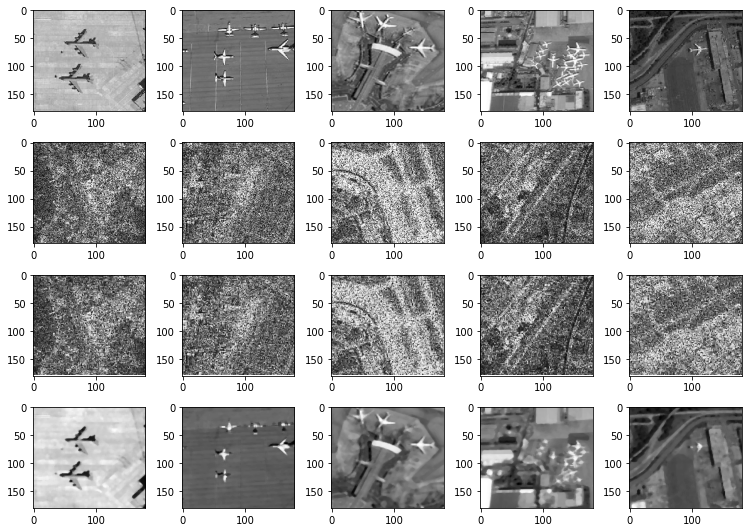

In [ ]:
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (180,180)), aspect='auto', cmap='gray') # Original image
        ax[1][i].imshow(np.reshape(y_true[i], (180,180)), aspect='auto', cmap='gray') # Noise Image
        ax[2][i].imshow(np.reshape(y_pred[i], (180,180)), aspect='auto', cmap='gray') # Denoised Image
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray') # Median Filter Image
       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

# **Model Prediction**

In [ ]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "zahidhussain909",
    "key": "39a06efd89d0f2a699143b8d3d62b216"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/kermany2018
!kaggle datasets download -d zahidhussain909/best-model-oct-denoising


import zipfile
zipref=zipfile.ZipFile("/content/kermany2018.zip",'r')
zipref.extractall()
zipref.close()

zipref=zipfile.ZipFile("/content/best-model-oct-denoising.zip",'r')
zipref.extractall()
zipref.close()

!rm -rf /content/kermany2018.zip
!rm -rf /content/best-model-oct-denoising.zip

 61% 6.63G/10.8G [02:50<01:48, 41.6MB/s]

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/best_model_OCT_denoising.h5")

1/1 [==============================] - 8s 8s/step


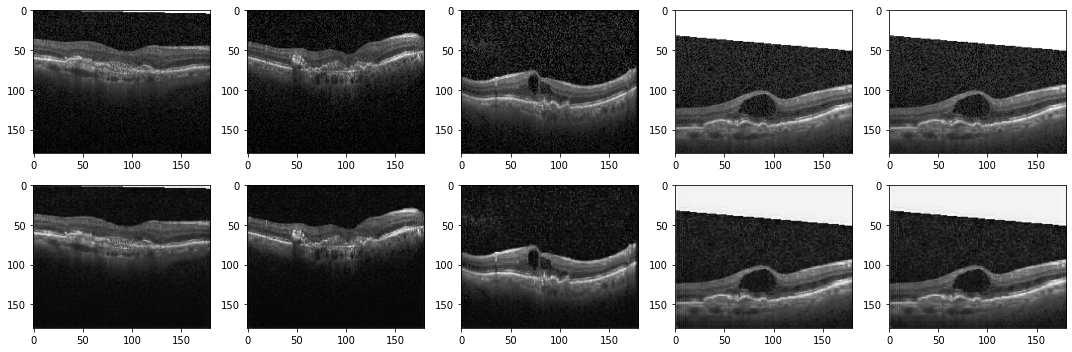

In [ ]:
import os
from keras.preprocessing import image
import tensorflow as tf 
import keras 
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras
import tensorflow as tf


val_images = sorted(os.listdir('/content/OCT2017 /train/CNV'))
val_images = val_images[:3500]
val_image = []
for im in val_images:
    img = tf.keras.utils.load_img('/content/OCT2017 /train/CNV/'+ im, target_size=(180,180), color_mode= 'grayscale')
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    val_image.append(img)
train_df = np.array(val_image)

import cv2

pred= model.predict(train_df[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 5)
    f.set_size_inches(15,5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(train_df[i], (180,180)), aspect='auto', cmap='gray') #original Input image
        #ax[1][i].imshow(np.reshape(y_true[i], (180,180)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_pred[i], (180,180)), aspect='auto', cmap='gray') #Denoised image
        #ax[2][i].imshow(cv2.medianBlur(train_df[i], (5)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(train_df[:5], pred[:5])

In [ ]:
pred= model.predict(train_df[5:6])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 5)
    f.set_size_inches(20,13)
    for i in range(5):
        ax[0][i].imshow(np.reshape(train_df[i], (180,180)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_pred[i], (180,180)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(train_df[:5], pred[:5])

1/1 [==============================] - 0s 255ms/step


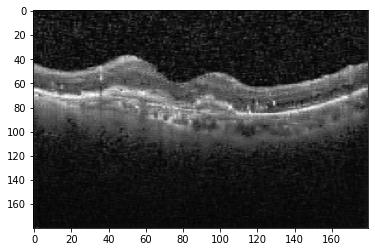

In [ ]:
pred= model.predict(train_df[100:101])
plt.imshow(np.reshape(pred, (180,180)), aspect='auto', cmap='gray')

In [ ]:
!mkdir orig
!mkdir denoised
def save_image(data, fn):
   
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
     
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
 
    ax.imshow(data, cmap='gray')
    plt.savefig(fn, dpi = height) 
    plt.close()

In [ ]:
for i in range(1,len(train_df)):
    pred= model.predict(train_df[i-1:i], verbose = 0)
    save_image(np.reshape(pred, (180,180)) ,"/content/denoised/" +str(i)+".png")
    save_image(np.reshape(train_df[prev:i], (180,180)), "/content/orig/" +str(i)+".png")

print("All Images Written to Disk")

All Images Written to Disk


In [ ]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np
scores = []
for i in range(1,len(train_df)):
    before = cv2.imread("/content/orig/" +str(i)+".png")
    after = cv2.imread("/content/denoised/" +str(i)+".png")
    before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)
    (score, diff) = structural_similarity(before_gray, after_gray, full=True)
    #print("Image similarity", score)
    scores.append(score)

mean_score = sum(scores)/len(scores)
print("Mean SSIM for " ,len(train_df)," images : ",mean_score)
print("Variance of SSIM for " ,len(train_df)," images : ",np.var(scores))
print("Standard Deviation of SSIM for " ,len(train_df)," images : ",np.std(scores, axis=0))

Mean SSIM for  3000  images :  0.7422178623692515
Variance of SSIM for  3000  images :  0.002534407506535923
Standard Deviation of SSIM for  3000  images :  0.050342899266291


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
values= []
def PSNR(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): 
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse))
	return psnr

for i in range(1,len(train_df)):
    original = cv2.imread("/content/orig/" +str(i)+".png")
    compressed = cv2.imread("/content/denoised/" +str(i)+".png")
    value = PSNR(original, compressed)
    values.append(value)

mean_score = sum(values)/len(values)
print("Mean PSNR for " ,len(train_df)," images : ",mean_score)
print("Variance of PSNR for " ,len(train_df)," images : ",np.var(values))
print("Standard Deviation of PSNR for " ,len(train_df)," images : ",np.std(values, axis=0))

Mean PSNR for  3000  images :  30.293021484929014
Variance of PSNR for  3000  images :  0.8442109486876486
Standard Deviation of PSNR for  3000  images :  0.9188095279695616


In [ ]:
from keract import display_activations
# The image path
img_path = '../images/brain-1.jpg'
# Preprocessing the image for the model
x = preprocess_image(img_path=img_path,model=model,resize=target_size)
# Generate the activations 
activations = get_activations(model, x)